In [ ]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_confidence_ellipse(mu, cov, alph, ax, clabel=None, label_bg='white', **kwargs):
    """Display a confidence ellipse of a bivariate normal distribution
    
    Arguments:
        mu {array-like of shape (2,)} -- mean of the distribution
        cov {array-like of shape(2,2)} -- covariance matrix
        alph {float btw 0 and 1} -- level of confidence
        ax {plt.Axes} -- axes on which to display the ellipse
        clabel {str} -- label to add to ellipse (default: {None})
        label_bg {str} -- background of clabel's textbox
        kwargs -- other arguments given to class Ellipse
    """
    c = -2 * np.log(1 - alph)  # quantile at alpha of the chi_squarred distr. with df = 2
    Lambda, Q = la.eig(cov)  # eigenvalues and eigenvectors (col. by col.)
    
    ## Compute the attributes of the ellipse
    width, heigth = 2 * np.sqrt(c * Lambda)
    # compute the value of the angle theta (in degree)
    theta = 180 * np.arctan(Q[1,0] / Q[0,0]) / np.pi if cov[1,0] else 0
        
    ## Create the ellipse
    if 'fc' not in kwargs.keys():
        kwargs['fc'] = 'None'
    level_line = Ellipse(mu, width, heigth, angle=theta, **kwargs)
    
    ## Display a label 'clabel' on the ellipse
    if clabel:
        col = kwargs['ec'] if 'ec' in kwargs.keys() and kwargs['ec'] != 'None' else 'black'  # color of the text
        pos = Q[:,1] * np.sqrt(c * Lambda[1]) + mu  # position along the heigth
        
        ax.text(*pos, clabel, color=col,
           rotation=theta, ha='center', va='center', rotation_mode='anchor', # rotation
           bbox=dict(boxstyle='round',ec='None',fc=label_bg, alpha=1)) # white box
        
    return ax.add_patch(level_line)

In [ ]:
from sklearn.cluster import KMeans
from scipy.special import digamma, gammaln, logsumexp
import time
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt



class VariationalGaussianMixture():
    """Variarional Bayesian estimation of a Gaussian mixture

    References
    ----------
        [1] Corduneanu, Adrian and Bishop, Christopher M. (2001), "Variational 
        Bayesian Model Selection for Mixture Distributions", in Proc. AI and 
        Statistics Conf., pp. 27-34."""

    def __init__(self, K, init_param="kmeans", seed=2208, max_iter=200, 
                 b0=None, alpha0=None, beta0=None,plot=False):
        self.b0 = b0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.K=K
        self.init_param = init_param
        self.rd = np.random.RandomState(seed)
        self.max_iter = max_iter
        self.plot=plot
    def _initialize(self, X):
        n_samples, D = X.shape
        self.alpha0 = self.alpha0 or D
        self.beta0 = self.beta0 or 1/np.diag(np.cov(X.T))
        self.b0 = self.b0 or 1.

        self.weights = np.ones(self.K) / self.K
      
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(X)
        MU_=kmeans.cluster_centers_
        ## Init expectations
        expect = {"T" : np.array([self.alpha0 /self.beta0 for _ in range(self.K)]),#[K,D]
                  "log_det_T" :np.array([digamma(self.alpha0)-np.log(self.beta0+1e-9) for _ in range(self.K)]),# np.zeros((self.K,D)),
                  #[K,D]
                  "mu" :MU_ ,  # (23)np.zeros((self.K, D))
                  "mu_mu" :np.array([(MU_[i]*MU_[i]) for i in range(self.K)]) }##np.zeros((self.K, D, D))
        
        '''
        if self.init_param == "random":
            resp = self.rd.rand(n_samples, self.K)
            resp /= resp.sum(axis=1)[:, np.newaxis]
        
        elif self.init_param == "kmeans":
            resp = np.zeros((n_samples, self.K))
            label = KMeans(n_clusters=self.K, n_init=1).fit(X).labels_
            resp[np.arange(n_samples), label] = 1

      
        
        else:
            raise ValueError("Correct values for 'init_param' are ['random', 'kmeans']")
        '''
        resp,_=self.compute_rho(X, expect)
        self._update_params(X, resp, expect)

    def _compute_expectations(self, D):
        exp_T =self.alpha.reshape(-1,1) /self.beta  # (25)
        exp_log_det_T = digamma(self.alpha.reshape(-1,1))-np.log(self.beta+1e-9) # (26)

        expect = {"T" : exp_T,#[K,D]
                  "log_det_T" : exp_log_det_T,#[K,D]
                  "mu" : np.copy(self.m),  # (23)[K,D]
                  "mu_mu" : np.zeros_like(self.S),#[K,D]
                  }
        
        invS = 1/self.S#[K,D]
        for k in range(self.K):
            
            expect["mu_mu"][k] = (invS[k]) + self.m[k]*self.m[k]
        return expect
    def compute_rho(self,X, expect):
        N, D = X.shape
        log_rho_tilde = np.zeros((N, self.K))
        for n in range(N):
            for k in range(self.K):
                log_rho_tilde[n, k] = -0.5*((X[n]*X[n] - 2*expect["mu"][k]*X[n] + expect["mu_mu"][k])@expect["T"][k])+0.5*np.sum(expect["log_det_T"][k]) # (17)
        log_rho = log_rho_tilde + np.log(self.weights + 10 * np.finfo(self.weights.dtype).eps)
        log_resp = log_rho - logsumexp(log_rho, axis=1)[:, np.newaxis]  # (16)
        resp=np.exp(log_resp)
        return resp, log_rho_tilde
       
    def _update_params(self, X, resp, expect):
        N, D = X.shape
        eta = resp.sum(axis=0) # sum_n (z_nk)
        self.alpha = self.alpha0 + 0.5*eta  # (20)    #[K,]
        self.S = self.b0 * np.ones(D) + expect["T"] * eta[:,np.newaxis]  # (18)[K,D] diag
        invS = 1/self.S
        
        self.beta = np.zeros((self.K, D))  # init (21)
        self.m = np.zeros((self.K, D))  # init (19)
        
        for k in range(self.K):
            self.m[k] = invS[k]*expect["T"][k] * (resp[:, k] @ X)  # (19)

            s = np.zeros(D)
            for n in range(N):
                s += resp[n, k] * (X[n]*X[n] - 2*expect["mu"][k]*X[n] + expect["mu_mu"][k])  # (21 --)
            self.beta[k] = self.beta0+ 0.5*s  # (-- 21)

    def _m_step(self, resp):
        self.weights = resp.sum(axis=0) / resp.sum()
    def _get_final_parameters(self):
        self.covs = self.beta/self.alpha.reshape(-1,1)
   

    def fit(self,X):
        _, D = X.shape
        self._initialize(X)

        self.elbo = np.empty(self.max_iter)
        for i in range(self.max_iter):
            expect = self._compute_expectations(D)
            resp,log_rho_tilde = self.compute_rho(X, expect)
          
            self._update_params(X, resp, expect)
            self._m_step(resp)
            #self.elbo[i] = self._compute_lower_bound(X, resp, log_rho_tilde, expect)
            #print(self.elbo[i])
            if i % 20 == 0:
                print("iteration",i)
                self._get_final_parameters()
                print("weights",self.weights)
                mean=self.m[self.weights>1e-3]
                cov=self.covs[self.weights>1e-3]
                #print(mean)
               # print(cov)
                #plot 
                if self.plot==True:
                    plt.figure()
                    ax = plt.gca()
                    for i in range(mean.shape[0]):
                        plot_confidence_ellipse(mean[i], np.diag(cov[i]), 0.95, ax, ec='crimson')
                    ax.scatter(X[:,0],X[:,1])
                    plt.show()
                #plot
        self._get_final_parameters()
        self.predict=np.argmax(resp,1)
        
        
       

In [ ]:
import numpy as np
m_true = np.array([[0, -2],[0, 0], [0, 2]])
covs_true = np.array([[[2, 0], [0, 0.2]], [[2, 0], [0, 0.2]], [[2, 0], [0, 0.2]]])
X = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])



In [ ]:
import numpy as np

m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3],[10, 10], [13, 7], [13,13], [7, 13], [7,7]])
covs_true = np.array([[[0.5, 0], [0, 0.5]], [[0.5, 0], [0, 0.5]], [[0.5, 0], [0, 0.5]], [[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]],[[0.5, 0], [0, 0.5]]])
z = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 500) for k in range(len(m_true))])
Y=np.concatenate([np.random.multivariate_normal(2*m_true[k], 0.5*covs_true[k], 500) for k in range(len(m_true))])
X=np.concatenate((z,Y),1)

In [ ]:
from scipy.special import digamma
digamma(beta0.reshape(-1,1))

array([[-1.9300884 ],
       [-2.95845304]])

In [ ]:

import numpy as np
with open('test.npy','rb') as f:
    y=np.load(f)
    X=np.load(f)
    o=np.load(f)

In [ ]:
m_true = np.random.randn(10, 100)
covs_true = 0.05*np.diag(np.ones(100))
X = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true, 1000) for k in range(len(m_true))])
y = np.concatenate([k*np.ones(1000) for k in range(10)])
X = (X - X.mean(axis=0)) / X.std(axis=0)


In [ ]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

iteration 0
weights [0.11080148 0.09398643 0.0830705  0.10386995 0.10189104 0.1023175
 0.09024526 0.10441446 0.10544027 0.1039631 ]


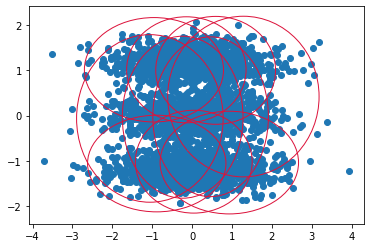

iteration 20
weights [0.10062812 0.09948648 0.03881569 0.11019171 0.09602789 0.13386892
 0.07730431 0.120906   0.11421829 0.10855258]


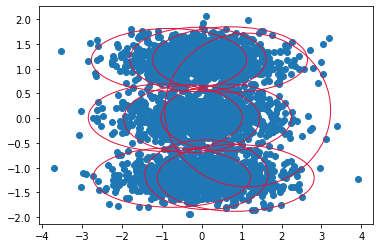

iteration 40
weights [0.08972261 0.10219306 0.01556264 0.10984908 0.09355066 0.14983979
 0.07497775 0.13351769 0.1193251  0.11146161]


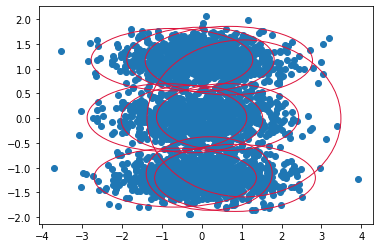

iteration 60
weights [0.0742042  0.1065071  0.00290112 0.10278415 0.09208804 0.16940209
 0.07157403 0.14119546 0.12457332 0.11477051]


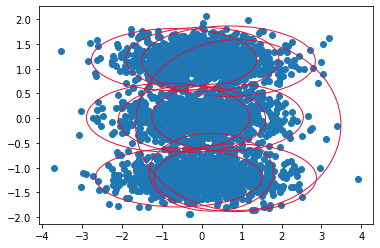

iteration 80
weights [5.59229177e-02 1.12054708e-01 3.14748437e-16 9.18359716e-02
 9.00854426e-02 1.91411808e-01 6.49562596e-02 1.44009119e-01
 1.30645348e-01 1.19078427e-01]


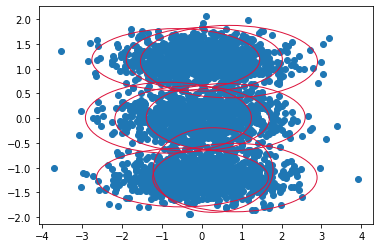

iteration 100
weights [3.72541569e-02 1.18557513e-01 2.48077145e-16 7.80963344e-02
 8.65357965e-02 2.15229023e-01 5.36663363e-02 1.45543409e-01
 1.38086605e-01 1.27030825e-01]


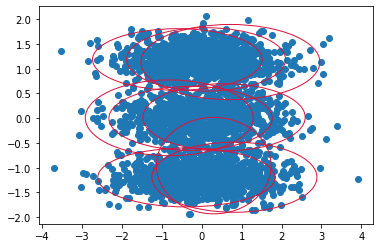

iteration 120
weights [2.18464420e-02 1.25558846e-01 2.49253781e-16 6.16942095e-02
 7.91039224e-02 2.39229723e-01 3.39186426e-02 1.46942349e-01
 1.47290451e-01 1.44415414e-01]


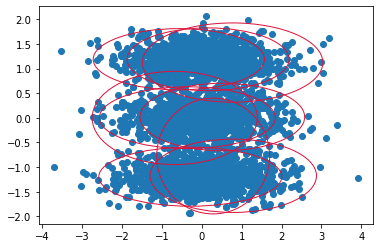

iteration 140
weights [9.42829202e-03 1.32555358e-01 2.50653011e-16 4.28687628e-02
 6.58680047e-02 2.62349947e-01 1.26474918e-02 1.48630785e-01
 1.58964212e-01 1.66687148e-01]


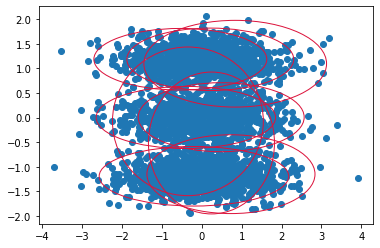

iteration 160
weights [6.37175591e-06 1.39316013e-01 2.51019750e-16 2.29118075e-02
 4.70587134e-02 2.88594233e-01 3.10691380e-04 1.47439634e-01
 1.74043812e-01 1.80318723e-01]


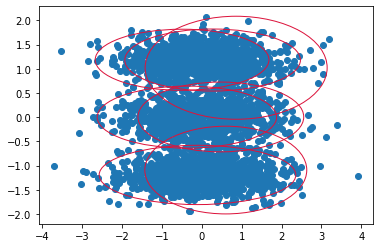

iteration 180
weights [2.50601064e-16 1.45116410e-01 2.50601064e-16 5.52652511e-03
 2.69473008e-02 3.10618089e-01 2.50601125e-16 1.38704363e-01
 1.85031613e-01 1.88055699e-01]


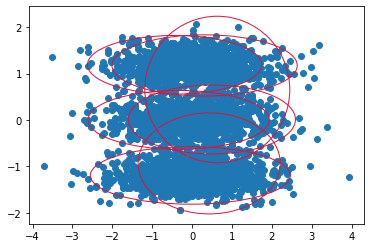

iteration 200
weights [2.50863156e-16 1.49653871e-01 2.50863156e-16 1.94487276e-12
 1.25675392e-02 3.24879997e-01 2.50863156e-16 1.28697162e-01
 1.83083649e-01 2.01117782e-01]


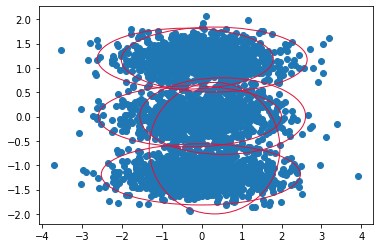

iteration 220
weights [2.51370224e-16 1.54111388e-01 2.51370224e-16 2.51370224e-16
 1.08187329e-03 3.30410429e-01 2.51370224e-16 1.16112307e-01
 1.77969384e-01 2.20314619e-01]


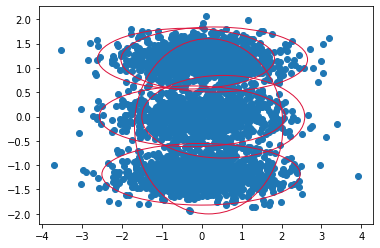

iteration 240
weights [2.51136813e-16 1.59174624e-01 2.51136813e-16 2.51136813e-16
 2.51152258e-16 3.29402071e-01 2.51136813e-16 9.66212797e-02
 1.72267939e-01 2.42534087e-01]


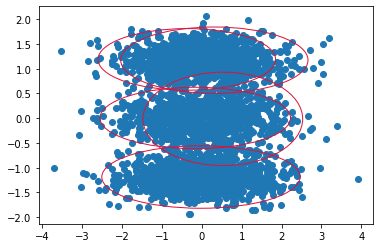

iteration 260
weights [2.51081483e-16 1.65105923e-01 2.51081483e-16 2.51081483e-16
 2.51081483e-16 3.27430021e-01 2.51081483e-16 7.35889931e-02
 1.65439628e-01 2.68435435e-01]


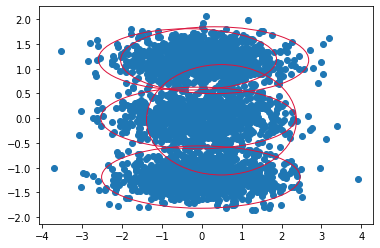

iteration 280
weights [2.51219284e-16 1.72948200e-01 2.51219284e-16 2.51219284e-16
 2.51219284e-16 3.25526313e-01 2.51219284e-16 5.36022649e-02
 1.57341917e-01 2.90581305e-01]


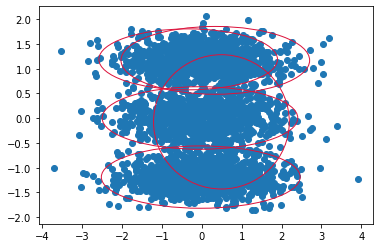

iteration 300
weights [2.51580926e-16 1.83456779e-01 2.51580926e-16 2.51580926e-16
 2.51580926e-16 3.25847728e-01 2.51580926e-16 3.92638287e-02
 1.47764914e-01 3.03666751e-01]


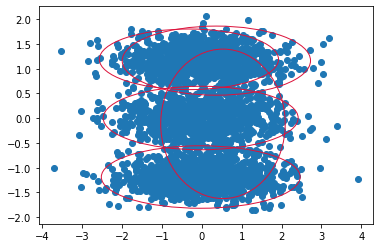

iteration 320
weights [2.51940159e-16 1.96346182e-01 2.51940159e-16 2.51940159e-16
 2.51940159e-16 3.27552079e-01 2.51940159e-16 2.88821644e-02
 1.36078772e-01 3.11140803e-01]


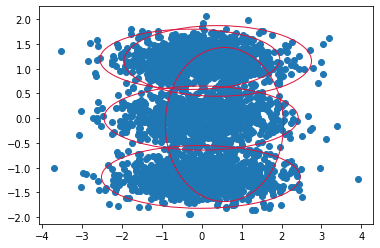

iteration 340
weights [2.52240349e-16 2.11476563e-01 2.52240349e-16 2.52240349e-16
 2.52240349e-16 3.29257455e-01 2.52240349e-16 2.06875141e-02
 1.22052934e-01 3.16525534e-01]


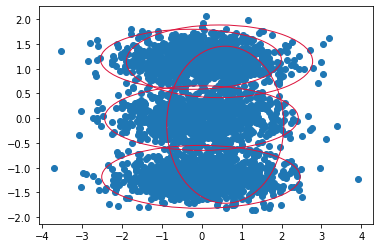

iteration 360
weights [2.52533616e-16 2.28940799e-01 2.52533616e-16 2.52533616e-16
 2.52533616e-16 3.31004471e-01 2.52533616e-16 1.27776480e-02
 1.05793226e-01 3.21483856e-01]


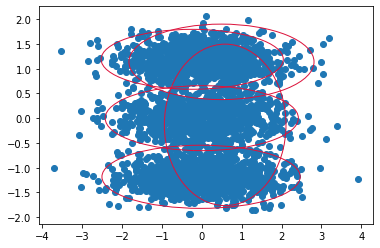

iteration 380
weights [2.52822502e-16 2.48775952e-01 2.52822502e-16 2.52822502e-16
 2.52822502e-16 3.33230083e-01 2.52822502e-16 3.41021601e-03
 8.75456038e-02 3.27038145e-01]


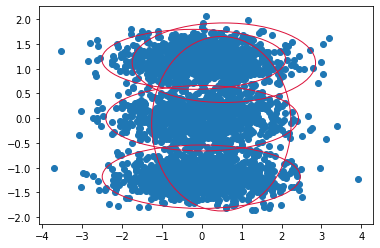

iteration 400
weights [2.52684072e-16 2.70224312e-01 2.52684072e-16 2.52684072e-16
 2.52684072e-16 3.34049266e-01 2.52684072e-16 2.70918579e-15
 6.72854752e-02 3.28440947e-01]


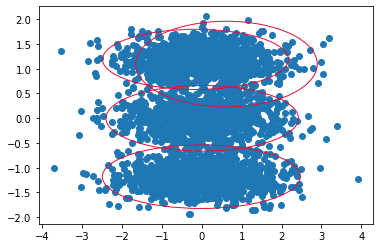

iteration 420
weights [2.52842878e-16 2.92278594e-01 2.52842878e-16 2.52842878e-16
 2.52842878e-16 3.34049087e-01 2.52842878e-16 2.52842878e-16
 4.61657882e-02 3.27506531e-01]


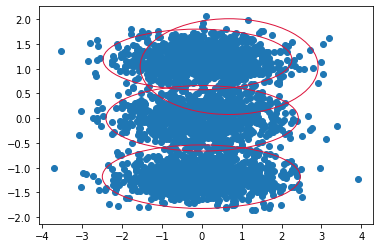

iteration 440
weights [2.53018864e-16 3.12958426e-01 2.53018864e-16 2.53018864e-16
 2.53018864e-16 3.33983936e-01 2.53018864e-16 2.53018864e-16
 2.68923967e-02 3.26165241e-01]


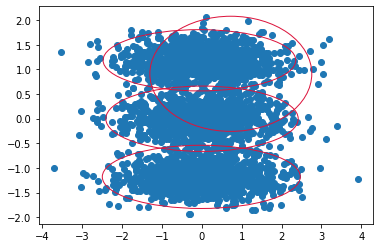

iteration 460
weights [2.53184607e-16 3.26324923e-01 2.53184607e-16 2.53184607e-16
 2.53184607e-16 3.33616541e-01 2.53184607e-16 2.53184607e-16
 1.43803775e-02 3.25678159e-01]


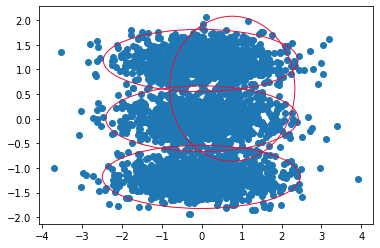

iteration 480
weights [2.53329934e-16 3.31300254e-01 2.53329934e-16 2.53329934e-16
 2.53329934e-16 3.33157116e-01 2.53329934e-16 2.53329934e-16
 7.00448004e-03 3.28538150e-01]


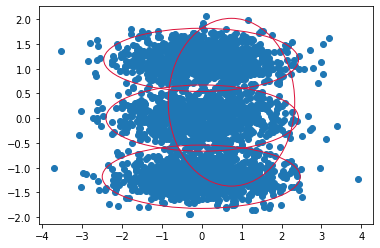

iteration 500
weights [2.53087781e-16 3.33613663e-01 2.53087781e-16 2.53087781e-16
 2.53087781e-16 3.33601508e-01 2.53087781e-16 2.53087781e-16
 9.59413143e-07 3.32783870e-01]


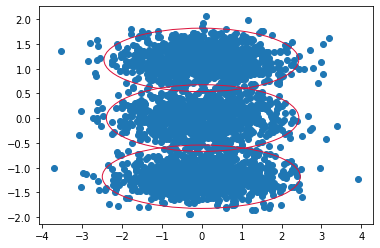

In [11]:
import time
start=time.time()
model = VariationalGaussianMixture(K=10,max_iter=501,init_param="kmeans",plot=True)
model.fit(X)
end=time.time()



In [ ]:
expect = model._compute_expectations(100)
resp,log_rho_tilde = model.compute_rho(X, expect)
predict=np.argmax(resp,1)

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment
import numpy as np
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

from sklearn.metrics import confusion_matrix


def cluster_acc(predicted_labels,labels):
    cm = confusion_matrix(labels, predicted_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    return np.trace(cm2)/np.sum(cm2),np.diag(cm2) / np.sum(cm2,0),cm2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


clustering accuracy

In [ ]:
cluster_acc(predict,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(1.0, array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan,
        nan]), array([[1000,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0, 1000,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0, 1000,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0, 1000,    0,    0,
         

In [ ]:
model.

In [ ]:
end-start#time

286.9623646736145

In [ ]:
model.m

array([[-1.03265773e-15,  2.57093167e-15],
       [ 7.65256734e-02,  3.24378287e-02],
       [-1.03265773e-15,  2.57093167e-15],
       [-1.03265773e-15,  2.57093167e-15],
       [ 5.70415874e-02, -2.02756542e+00],
       [-1.03265773e-15,  2.57093167e-15],
       [ 1.54110568e-02,  1.98851168e+00],
       [-1.03265773e-15,  2.57093167e-15],
       [-1.03265773e-15,  2.57093167e-15],
       [-1.00832277e+00, -2.62022586e-01]])

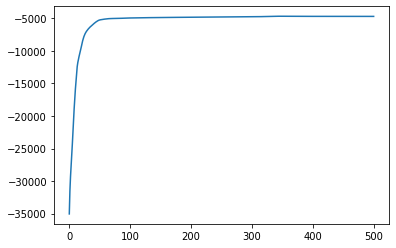

In [ ]:
plt.plot(range(len(model.elbo)),model.elbo)



In [ ]:
mean=model.m[model.weights>1e-5]

In [ ]:
cov=model.covs[model.weights>1e-5]

In [ ]:
cov

array([[0.51272214, 5.22591247],
       [0.51526514, 5.43805524],
       [0.49501735, 4.83575335],
       [0.70412056, 3.08220082]])

In [ ]:
mean

array([[ 0.07652567,  0.03243783],
       [ 0.05704159, -2.02756542],
       [ 0.01541106,  1.98851168],
       [-1.00832277, -0.26202259]])

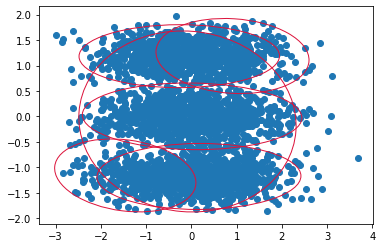

In [ ]:

plt.figure()
ax = plt.gca()
for i in range(mean.shape[0]):
    plot_confidence_ellipse(mean[i], cov[i], 0.95, ax, ec='crimson')
ax.scatter(X[:,0],X[:,1])
plt.show()

In [ ]:
mean

array([[ 1.32432114,  0.82610849],
       [ 0.25445957,  0.14004446],
       [-0.49975293,  1.4543343 ],
       [-1.87475029,  0.40016818],
       [ 1.54687784, -0.35379908],
       [ 0.44837299,  1.29059712],
       [-1.07768317,  0.08956754],
       [-0.66643068,  0.14687971],
       [ 0.41051239, -0.89433649],
       [-0.31435802,  1.06823412],
       [ 0.13900296, -0.22141885],
       [ 0.21169094, -1.88815302],
       [-0.65128841, -0.85921389]])